# Echo State Network
Here, we validate the hyperparameters of the ESN. Note that the ESN is only trained on the encoded latent space representation. 

In [ ]:
import matplotlib as mpl
import pickle
import json
from pathlib import Path
# import torch
import sys
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# device = torch.device("cpu")
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')

sys.path.append('../')
from src.neuralnetwork.autoencoder import CAE
from src.neuralnetwork.preprocessing import generate_esn_noise_data, train_valid_test_split
from src.neuralnetwork.preprocessing import generate_esn_noise_data, train_valid_test_split
sys.path.insert(0, '../../EchoStateNetwork/') # you need to get the git repo https://github.com/MagriLab/EchoStateNetwork
from esn.esn import ESN
from esn.validation import validate
from esn.utils import errors, scalers

from npesn import validation
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".95"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"
import jax
jax.config.update("jax_enable_x64", True)
import functools
import jax
import jax.numpy as jnp

#### 1: Load the trained CAE and the encoded time series

In [19]:
cae_path = Path('../weights/fluent-sweep-2/')
with open(cae_path/'ks.json') as f:
    ks_data = json.load(f)
print(ks_data)

with open(cae_path /'encoded_ks.npy', 'rb') as f:
    U_encoded = np.load(f)
print(f"Encoded timeseries {U_encoded.shape}")

{'upsample': 4, 'L': 22, 'N_data': 400000, 'N_trans': 1000, 'dt': 0.05, 'Nx': 512, 'train_ratio': 0.8, 'valid_ratio': 0.1, 'batchsize': 128, 'normtype': 'max', 'lyap': 0.04}
Encoded timeseries (399801, 8)


#### 2: Prepare the encoded data for the ESN training

In [20]:
U_esn = generate_esn_noise_data(U_encoded, 1, sigma_n=1e-3)
u_encoded_train, u_encoded_valid, u_encoded_test = train_valid_test_split(U_esn, ks_data)

In [21]:
total_samples, dim = u_encoded_train.shape
N_washout = 200
train_size = min(len(u_encoded_train)-N_washout-101, 100000)#-1001
val_size = min(len(u_encoded_valid)-101-N_washout, 20001)
test_N_washout = 100
# Split the data into different datasets
U_washout = u_encoded_train[:N_washout, ...]
U_train_input = u_encoded_train[N_washout:N_washout+train_size-1, ...]
U_train_label = u_encoded_train[N_washout + 1:N_washout+train_size, ...]
U_val_input = u_encoded_valid[:val_size-1, ...]
U_val_label = u_encoded_valid[1:val_size, ...]
U_test_washout = u_encoded_test[:test_N_washout, ...]
U_test = u_encoded_test[N_washout:, ...]
# Print shapes of datasets
print(f"Training data shape: {U_train_input.shape, U_train_label.shape}")
print(f"U_val shape: {U_val_input.shape, U_val_label.shape}")
print(f"U_test shape: {U_test.shape}")

Training data shape: ((99999, 8), (99999, 8))
U_val shape: ((20000, 8), (20000, 8))
U_test shape: (39601, 8)


#### 3: Validate the hyperparameters of the ESN

In [22]:
#  specify which hyperparameters to search, e.g., spectral_radius, input_scaling, leak_factor
hyperparameter_dict = {
    'spectral_radius': [0.1, 1.0, 'uniform'],
    'input_scaling': [0.01, 10.0, 'log10'],
    'tikhonov': [1e-12, 1e-3, 'log10'],
    # 'leak_factor': [0.1, 1.0, 'uniform']  # Uncomment if needed
}
grid_range = []
for i, parameter in enumerate(hyperparameter_dict.keys()):
    scaler = getattr(scalers, hyperparameter_dict[parameter][-1])
    grid_range.append(scaler(hyperparameter_dict[parameter][:2]))

# compute normalization factor (range component-wise)
U_data = U_esn[:N_washout+train_size, :dim].copy()
m = U_data.min(axis=0)
M = U_data.max(axis=0)
norm = M-m
u_mean = U_data.mean(axis=0)

N_val = 1000  # number of validation steps

#### 4: Select the best ESN hyperparameters
We provide hyperparameters from the ESN that we validated. 

In [26]:
with open(cae_path / 'esn_best_dict.pkl', 'rb') as f:
    esn_loaded_dict = pickle.load(f)

print(f"Dictionary loaded in {esn_loaded_dict}")
i=0
my_ESN = ESN(reservoir_size=esn_loaded_dict["reservoir_size"],
                dimension=esn_loaded_dict["dimension"],
                reservoir_connectivity=esn_loaded_dict["reservoir_connectivity"],
                spectral_radius=esn_loaded_dict['spectral_radius'][i],
                input_scaling=esn_loaded_dict['input_scaling'][i],
                tikhonov=esn_loaded_dict['tikhonov'][i],
                input_bias=esn_loaded_dict["input_bias"],
                # output_bias=esn_loaded_dict["output_bias"],
                reservoir_weights_mode=esn_loaded_dict['reservoir_weights_mode'],
                input_normalization=esn_loaded_dict['input_normalization'],
                # input_weights_mode=esn_loaded_dict['input_weights_mode'],
                #   leak_factor =min_dict['leak_factor'][i],
                input_seeds=esn_loaded_dict["input_seeds"],
                reservoir_seeds=esn_loaded_dict["reservoir_seeds"], verbose=False)
%timeit my_ESN.train(U_washout, U_train_input, U_train_label)

Dictionary loaded in {'f': array([0.94888783, 0.9791983 , 0.98330447, 0.99656125, 1.00516251]), 'spectral_radius': array([0.86252656, 0.69568148, 0.68466838, 0.92127484, 0.68335468]), 'input_scaling': array([0.74249082, 0.14275035, 0.12883642, 0.79795807, 0.12726958]), 'tikhonov': array([1.e-09, 1.e-03, 1.e-03, 1.e-09, 1.e-03]), 'reservoir_size': 5000, 'dimension': 8, 'reservoir_connectivity': 10, 'input_bias': array([1]), 'output_bias': array([1]), 'reservoir_weights_mode': 'erdos_renyi1', 'input_normalization': [array([-0.00593858, -0.04789577,  0.01191856,  0.03158609, -0.03616858,
        0.04105314, -0.00360776,  0.01144325]), array([1.11553235, 1.08183018, 1.10016882, 1.06189767, 1.08552729,
       1.07920115, 1.16133172, 1.06537837])], 'input_seeds': [0, 1, 2], 'reservoir_seeds': [3, 4]}


/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.64861e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.64861e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


KeyboardInterrupt: 

In [8]:
%timeit reservoir, prediction = my_ESN.closed_loop_with_washout(U_test_washout, 5000)

862 ms ± 73.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### 5: CAE-ESN prediction on the test data

In [15]:
cae_model = CAE(8)
cae_model.load_state_dict(torch.load(cae_path/"best_model.pth", map_location=device))
cae_model = cae_model.to(device)

AttributeError: 'ESN' object has no attribute 'closed_loop_with_washout'

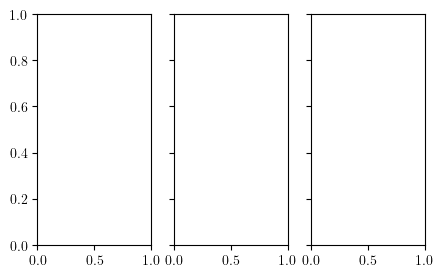

In [16]:

# Define constants
N_lyap = int(1/ks_data["lyap"]/(ks_data["dt"]*ks_data["upsample"]))
N_plot = 5*N_lyap
fs = 14
cmap = 'RdBu_r'

# Calculate domain length
domain_length = 20 * np.pi

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(5,3), sharey=True)  # Changed ncols to 1

N_start = 200 
reservoir, prediction = my_ESN.closed_loop_with_washout(u_encoded_test[N_start:N_start+N_washout, :dim], 15000)
snapshot_decoded = cae_model.decoder(torch.from_numpy(prediction).float().to(device)).numpy(force=True)
snapshot = cae_model.decoder(torch.from_numpy( u_encoded_test[N_start+N_washout:N_start+N_washout+15000, :dim]).float().to(device)).numpy(force=True)


# Extract data
data1 = snapshot[:N_plot, 0, :] 
data2 = snapshot_decoded[:N_plot, 0, :] 
data3 = data1 - data2

lyapunov_time = ks_data["lyap"] * np.arange(0, 10000, (ks_data["dt"]*ks_data["upsample"]))
# Adjust subplot spacing
plt.subplots_adjust(wspace=-0.05)  #
# Plot data
for i, data in enumerate([data1, data2, data3]):
    axes = axs[i]
    im = axes.imshow(data, aspect='auto', cmap=cmap,
                     extent=[0, 2 * 4 * np.pi, int(lyapunov_time[N_plot]), lyapunov_time[0]])


    axes.set_xlabel('x', fontsize=fs, rotation=0, labelpad=0, y=0.46)
     # Set y-tick labels and font size
    axes.set_yticks(axes.get_yticks())  # Ensure yticks are set first
    axes.set_yticklabels([f'{int(tick)}' for tick in axes.get_yticks()], fontsize=fs)

    axes.yaxis.tick_left()
    axes.set_xticks(np.arange(0, 8 * np.pi + 0.01, step=(1 * 4 * np.pi)), ['0', r'$4\pi$', r'8$\pi$'],
                    fontsize=fs)
    for tick_label in axes.get_xticklabels():
        tick_label.set_ha('center')
        tick_label.set_x(-0.05)

    cbar = fig.colorbar(im, ax=axes)
    cbar.ax.tick_params(labelsize=fs)

axs[0].set_ylabel(r'$\tau_{\lambda}$', fontsize=fs)
axs[0].set_title("Reference")
axs[1].set_title("CAE")
axs[2].set_title("Error")
# Show or save plot
plt.tight_layout()
# plt.savefig("../images/cae-esn.png", dpi=100)


In [10]:
sys.path.append('../')
from data_assimilation.enkf import EnKF

In [11]:
# Kalman Parameters
np.random.seed(123)
std_obs=0.01
N_ensemble = 20
repeats = 20
N_steps = N_lyap//4
washout_size = N_washout
#input data
inputdim =8
N_start =1000
washout_observations = U_test[N_start:N_start+washout_size, :inputdim]
truth =  U_test[washout_size+N_start:, :]

washout_noise_ensemble = washout_observations + np.random.normal(loc=0.0, scale=std_obs*np.std(U_encoded, axis=0), size=(N_ensemble, washout_size, inputdim))
observations_ensemble = truth[:, :inputdim] + np.random.normal(loc=0.0, scale=std_obs*np.std(U_encoded, axis=0), size=(N_ensemble, truth.shape[0], inputdim))
measurements = truth[::N_steps]
obs_ensemble = np.zeros(shape=(N_ensemble, N_steps, esn_loaded_dict["reservoir_size"]))
obs_ensemble_step = np.zeros(shape=(N_ensemble, N_steps, esn_loaded_dict["reservoir_size"]))



Cdd = np.diag((std_obs * np.ones(inputdim))) #* np.max(abs(observations), axis=0) ** 2
M = my_ESN.W_out[:, :inputdim].T
Aa_tracked = np.zeros(shape=(repeats, inputdim, N_ensemble))

for i in range(N_ensemble):
    reservoir, prediction  = my_ESN.closed_loop_with_washout(washout_noise_ensemble[i], N_steps-1)
    obs_ensemble[i] = reservoir[:] # np.append(prediction, reservoir, axis=1)

for j in range(repeats):
    n_t_current = obs_ensemble.shape[1]-1
    Aa = EnKF(Af=obs_ensemble[:, -1, :].T, d=observations_ensemble[:, n_t_current, :].T, Cdd=Cdd, M=M)
    Aa_tracked[j] = (Aa.T @ my_ESN.W_out).T
    
    for i in range(N_ensemble):
        reservoir, prediction  = my_ESN.closed_loop(Aa[:, i], N_steps)
        obs_ensemble_step[i] = reservoir[1:] #np.append(prediction[1:], reservoir[1:], axis=1)
    obs_ensemble = np.append(obs_ensemble, obs_ensemble_step, axis=1)


In [12]:
# Figures colors
color_true = 'gray'
color_unbias = '#000080ff'
color_bias = '#20b2aae5'
color_obs = 'r'
color_b = 'indigo'
colors_alpha = ['green', 'sandybrown', [0.7, 0.7, 0.87], 'blue', 'red', 'gold', 'deepskyblue']

y_unbias_props = dict(marker='none', linestyle='--', dashes=(10, 1), lw=.5, color=color_unbias)
esn_ens_props = dict(marker='none', linestyle='-', lw=.2, color=color_bias, alpha=.9)
washout_ens_props = dict(marker='none', linestyle='-', lw=.2, color="k", alpha=.7)
washout_ens_props = dict(marker='none', linestyle='-', lw=.2, color="k", alpha=.9)

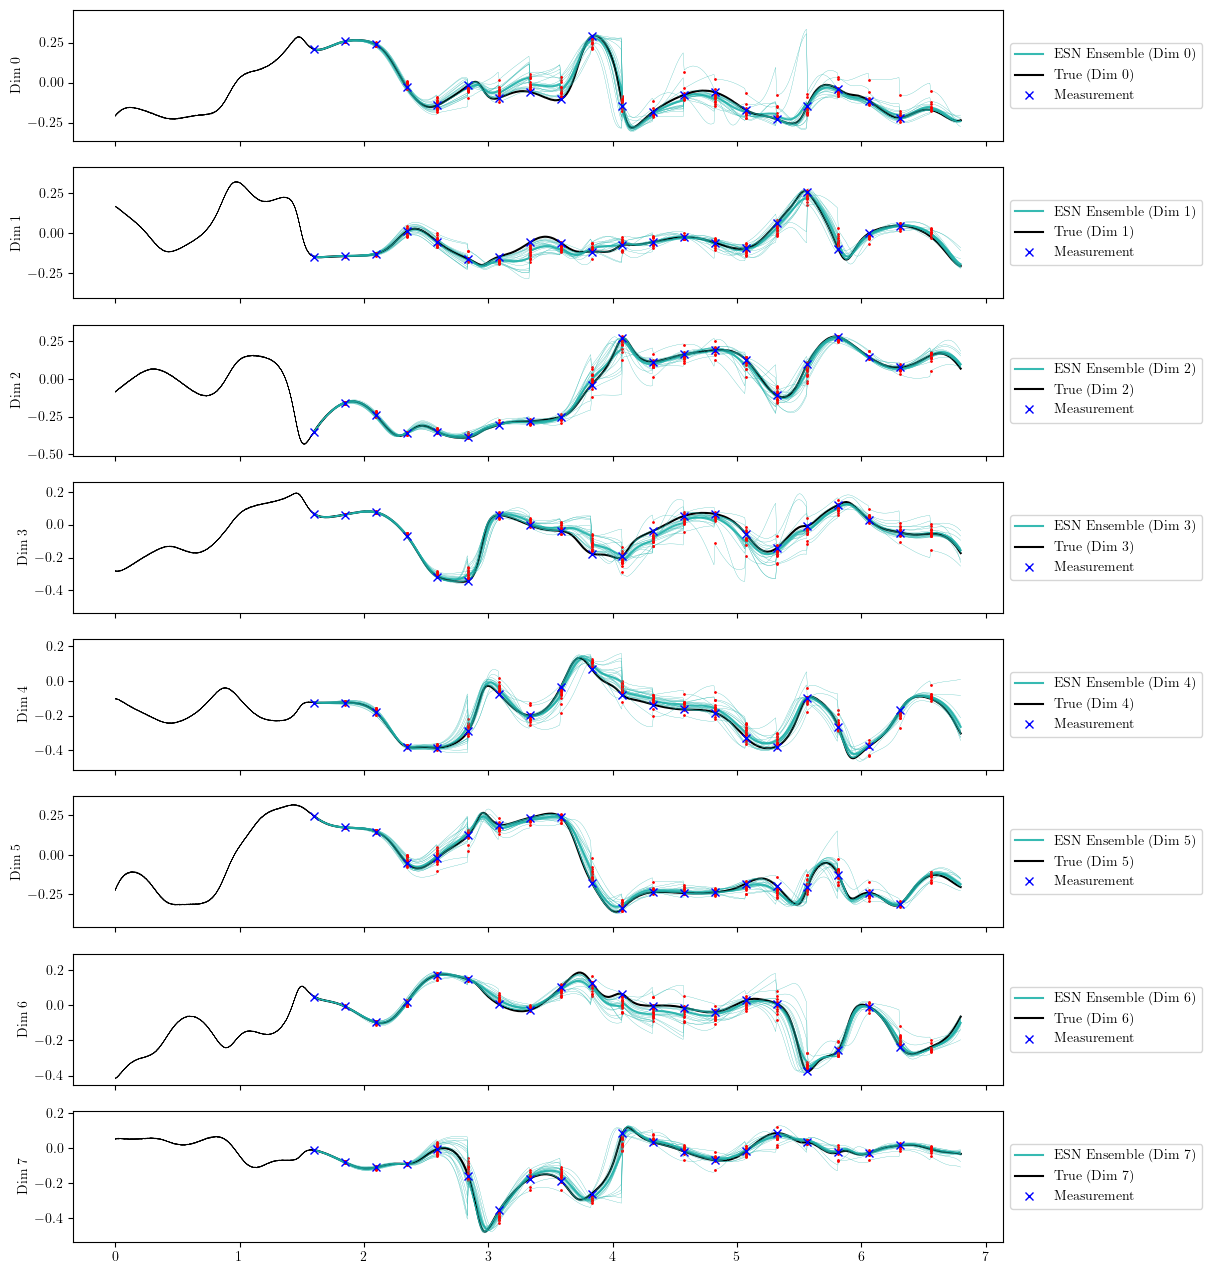

In [55]:
dt =  ks_data["lyap"] * (ks_data["dt"]*ks_data["upsample"])
time_A_tracked = np.arange(washout_size, obs_ensemble.shape[1] + washout_size, step=N_steps) * dt
measurements = measurements[:repeats]

# Define the number of dimensions based on the predictions array
N_dims = 8

fig, axs = plt.subplots(N_dims, 1, figsize=(12, 2 * N_dims), sharex=True)
time_prediction = np.arange(washout_size, obs_ensemble.shape[1] + washout_size) * dt
time_washout = np.arange(0, washout_size) * dt

predictions = (obs_ensemble @ my_ESN.W_out)

for dim in range(N_dims):
    axs[dim].plot(time_prediction, np.mean(predictions[:, :, dim], axis=0), color=color_bias, label=f"ESN Ensemble (Dim {dim})")
    axs[dim].plot(time_prediction, truth[:len(time_prediction), dim], "k", label=f"True (Dim {dim})")
    
    for mi in range(obs_ensemble.shape[0]):
        axs[dim].plot(time_washout, washout_noise_ensemble[mi, :, dim], **washout_ens_props)
        axs[dim].plot(time_prediction, predictions[mi, :, dim], **esn_ens_props)
        axs[dim].plot(time_A_tracked[1:], Aa_tracked[:, dim, mi], ".", color="r", markersize=2)
        
    axs[dim].plot(time_A_tracked[:-1], measurements[:, dim], "x", color="b", markersize=6, label="Measurement")
    axs[dim].set_ylim(np.min(U_encoded[:, dim]), np.max(U_encoded[:, dim]))
    axs[dim].set_ylabel(f"Dim {dim}")
    axs[dim].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


/tmp/ipykernel_949808/1220574530.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


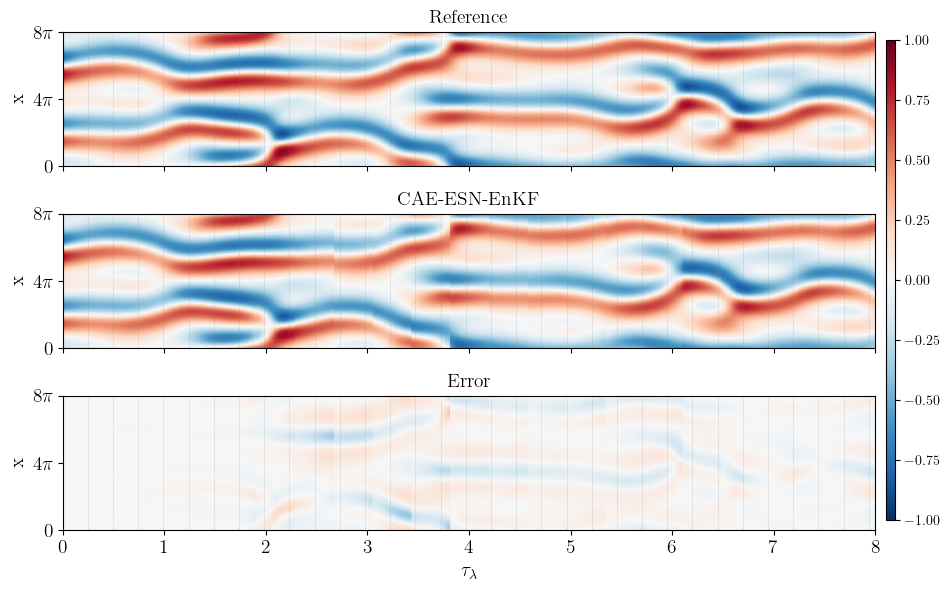

In [56]:
mean_prediction = np.mean(predictions, axis=0)
snapshot_decoded = cae_model.decoder(torch.from_numpy(prediction).float().to(device)).numpy(force=True)
snapshot = cae_model.decoder(torch.from_numpy( u_encoded_test[N_start+N_washout:N_start+N_washout+N_plot, :8]).float().to(device)).numpy(force=True)


# Define constants
cmap = 'RdBu_r'
fs = 14
domain_length = 8 * np.pi
N_plot = 1000

# Create subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(9, 6), sharex=True)  # Three subplots on top of each other

snapshot_decoded = cae_model.decoder(torch.from_numpy(mean_prediction).float().to(device)).numpy(force=True)
snapshot = cae_model.decoder(torch.from_numpy(truth[:len(time_prediction), :]).float().to(device)).numpy(force=True)

# Extract data
data1 = snapshot[:N_plot, 0, :] 
data2 = snapshot_decoded[:N_plot, 0, :] 
data3 = data1 - data2

# Calculate min and max values for color scale across all datasets
vmin = -1
vmax = 1
lyapunov_time = ks_data["lyap"] * np.arange(0, 10000, (ks_data["dt"] * ks_data["upsample"]))

# Adjust subplot spacing
plt.subplots_adjust(hspace=0.4)  # Adjust vertical space between plots

# Plot data with axis switched
for i, data in enumerate([data1, data2, data3]):
    axes = axs[i]
    im = axes.imshow(data.T, aspect='auto', cmap=cmap, origin='lower',
                     extent=[int(lyapunov_time[0]), (lyapunov_time[N_plot]), 0, 8 * np.pi],
                     vmin=vmin, vmax=vmax)  # Set color scale limits
    for x in lyapunov_time[:N_plot:N_steps]:
    #     if lyapunov_time[x] < int(lyapunov_time[N_plot]):
        axes.axvline(x=x, color='k', linestyle='--', linewidth=0.5, c="grey", alpha=0.3)


    # Set axis labels
    axes.set_ylabel('x', fontsize=fs)
    axes.set_yticks(np.arange(0, 8 * np.pi + 0.01, step=(1 * 4 * np.pi)))
    axes.set_yticklabels(['0', r'$4\pi$', r'$8\pi$'], fontsize=fs)

    axes.set_xticks(axes.get_xticks())
    axes.set_xticklabels([f'{int(tick)}' for tick in axes.get_xticks()], fontsize=fs)

# Add a single color bar for all plots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([.99, 0.125, 0.01, .8])
fig.colorbar(im, cax=cbar_ax)

# Set titles and x-axis for the last plot
axs[0].set_title("Reference", fontsize=fs)
axs[1].set_title("CAE-ESN-EnKF", fontsize=fs)
axs[2].set_title("Error", fontsize=fs)

axs[2].set_xlabel(r'$\tau_{\lambda}$', fontsize=fs)  # Set xlabel on the last subplot
plt.tight_layout()
plt.show()

